# ACTPol Likelihood Analysis (DR4 release)

## Preamble

This notebook make use of [GetDist](https://getdist.readthedocs.io/en/latest/) python package to plot and to analyse MCMC samples.



In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

Print versions used



In [2]:
import getdist
import matplotlib

getdist.chains.print_load_details = False

print("     Numpy :", np.__version__)
print("Matplotlib :", matplotlib.__version__)
print("   GetDist :", getdist.__version__)

     Numpy : 1.20.0
Matplotlib : 3.3.3
   GetDist : 1.1.2


We will use the `cobaya_utilities` module to ease some plotting like how the chains evolve

In [3]:
!pip install git+https://github.com/xgarrido/cobaya_utilities.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/xgarrido/cobaya_utilities.git to /tmp/pip-req-build-8calc5sc
  Running command git clone -q https://github.com/xgarrido/cobaya_utilities.git /tmp/pip-req-build-8calc5sc
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


## Definitions

Define CMB & nuisance parameter names.



In [4]:
cosmo_params = ["cosmomc_theta", "logA", "ns", "ombh2", "omch2", "H0", "tau"]
polareff_params = [f"yp{i}" for i in range(10)]
leakage_params = [f"bl{i}" for i in range(10)]

Set a dictionnary holding the path to the MCMC chains and its name

In [5]:
mcmc_samples = {
    "ACTPol - polar eff. - TE+EE": "data/polareff/te_ee",
    "ACTPol - polar eff. - TT+TE+EE": "data/polareff/tt_te_ee",
    "ACTPol - TE leakage - TE+EE": "data/leakage/te_ee",
    "ACTPol - TE leakage - TT+TE+EE": "data/leakage/tt_te_ee",
}

## MCMC chains

Let's plot the chains size

In [25]:
from cobaya_utilities.tools import print_chains_size

print_chains_size(mcmc_samples.values(), list(mcmc_samples.keys()))

,mcmc 1,mcmc 2,mcmc 3,mcmc 4,total
ACTPol - polar eff. - TE+EE,16142,15226,12069,15903,59340
ACTPol - polar eff. - TT+TE+EE,25396,24409,21353,20427,91585
ACTPol - TE leakage - TE+EE,14408,15997,13893,14252,58550
ACTPol - TE leakage - TT+TE+EE,25230,26916,24413,25356,101915


Have a look at how chains evolve with time and check convergence or not.



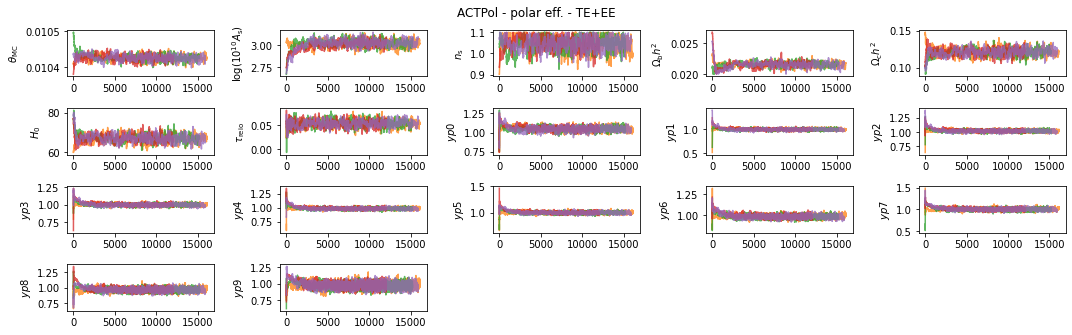

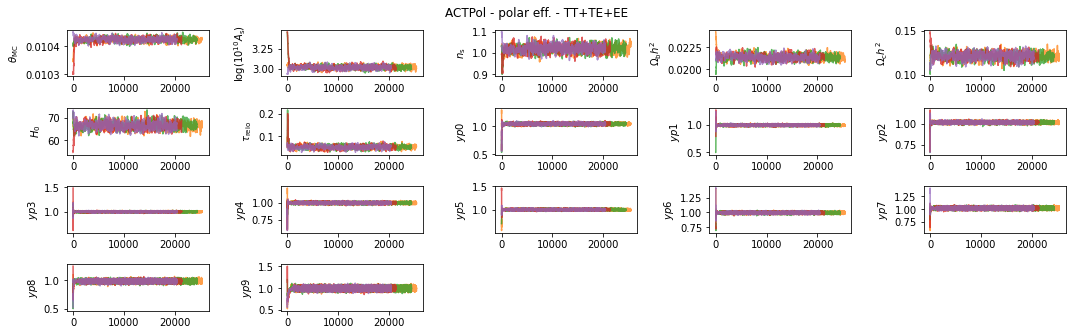

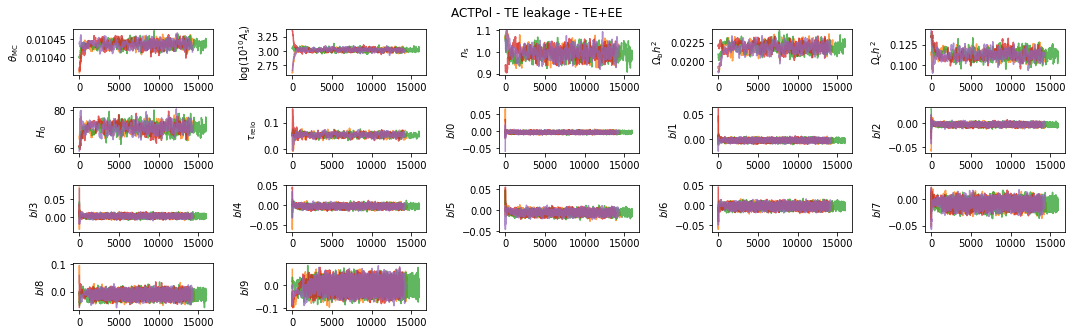

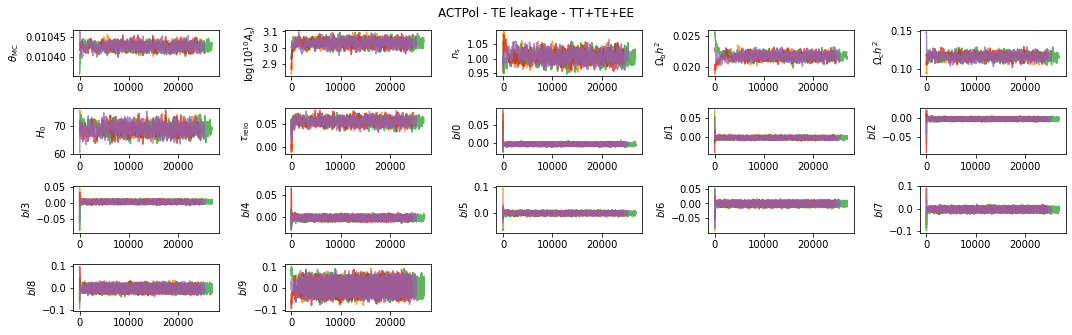

In [26]:
from cobaya_utilities.tools import plot_chains

for k, v in mcmc_samples.items():
    nuisance_params = polareff_params if "polar eff." in k else leakage_params
    plot_chains(v, params=cosmo_params + nuisance_params, title=k, ncol=5)

Let's plot also the Gelman $R-1$ parameter and acceptance rate progress

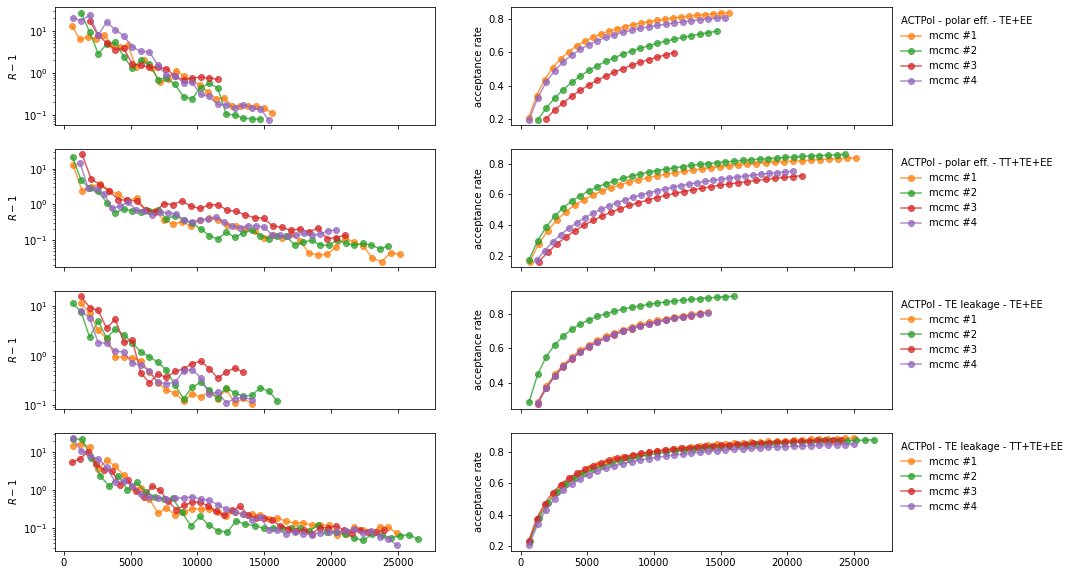

In [27]:
from cobaya_utilities.tools import plot_progress

plot_progress(mcmc_samples.values(), list(mcmc_samples.keys()))

## MCMC distributions



Define global plot settings

In [9]:
from getdist.plots import GetDistPlotSettings

plot_settings = GetDistPlotSettings()
plot_settings.num_plot_contours = 3
plot_settings.solid_colors = "Paired"
plot_settings.line_styles = "Paired"
plot_settings.legend_fontsize = 15

Load MCMC samples



In [28]:
from getdist import loadMCSamples

samples = [
    loadMCSamples(os.path.join(path, "mcmc"), settings={"ignore_rows": 0.4})
    for path in mcmc_samples.values()
]

Plot posteriors distributions of CMB parameters



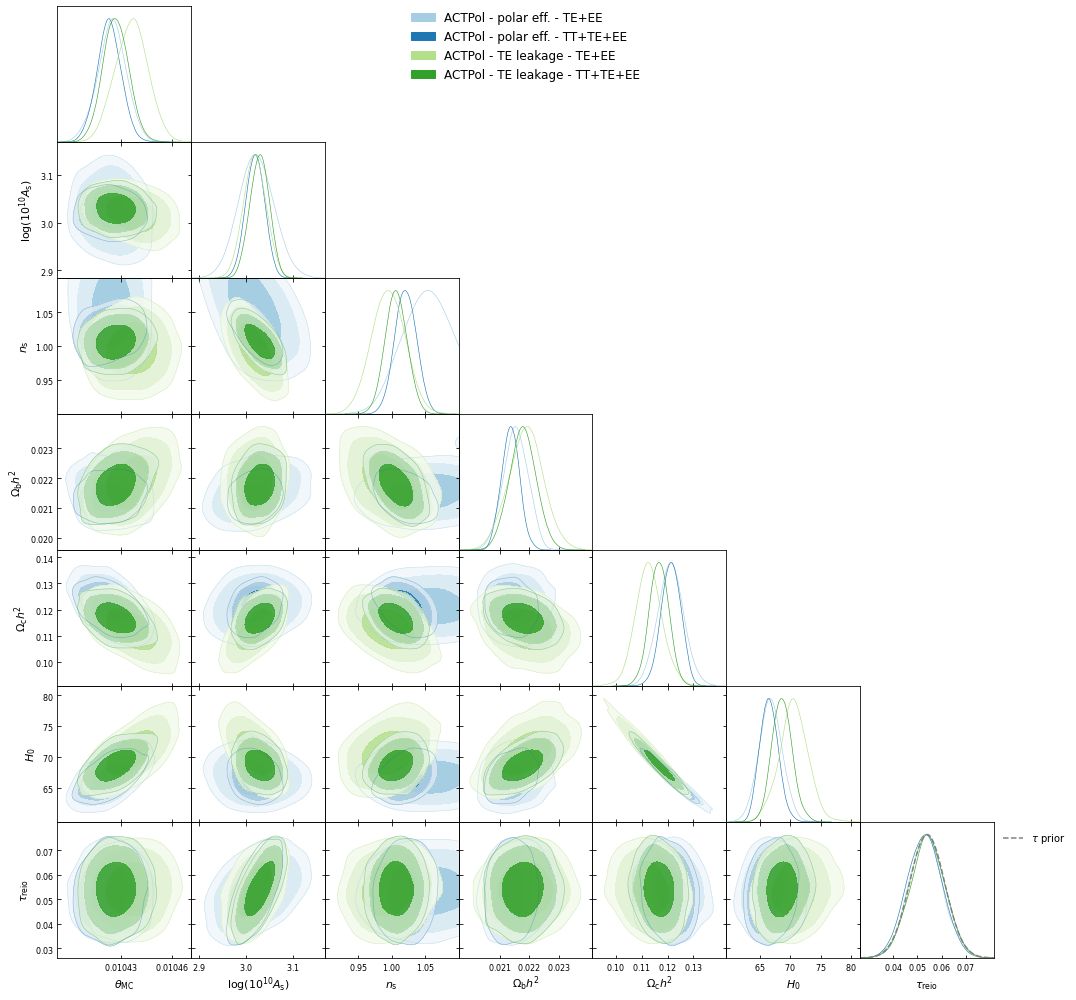

In [29]:
from getdist import plots

g = plots.get_subplot_plotter(settings=plot_settings)
colors = [plt.get_cmap("Paired")(i) for i in range(4)]
g.triangle_plot(
    samples,
    cosmo_params,
    filled=True,
    legend_labels=mcmc_samples.keys(),
    colors=colors,
    diag1d_kwargs={"colors": colors},
)
# Show prior on tau
from scipy.stats import norm

ax = g.subplots[-1, -1]
xmin, xmax, ymin, ymax = ax.axis()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, 0.054, 0.0073)

ax.plot(x, y / np.max(y), color="gray", ls="--", label=r"$\tau$ prior")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1));

Plot posteriors distributions of nuisance parameters



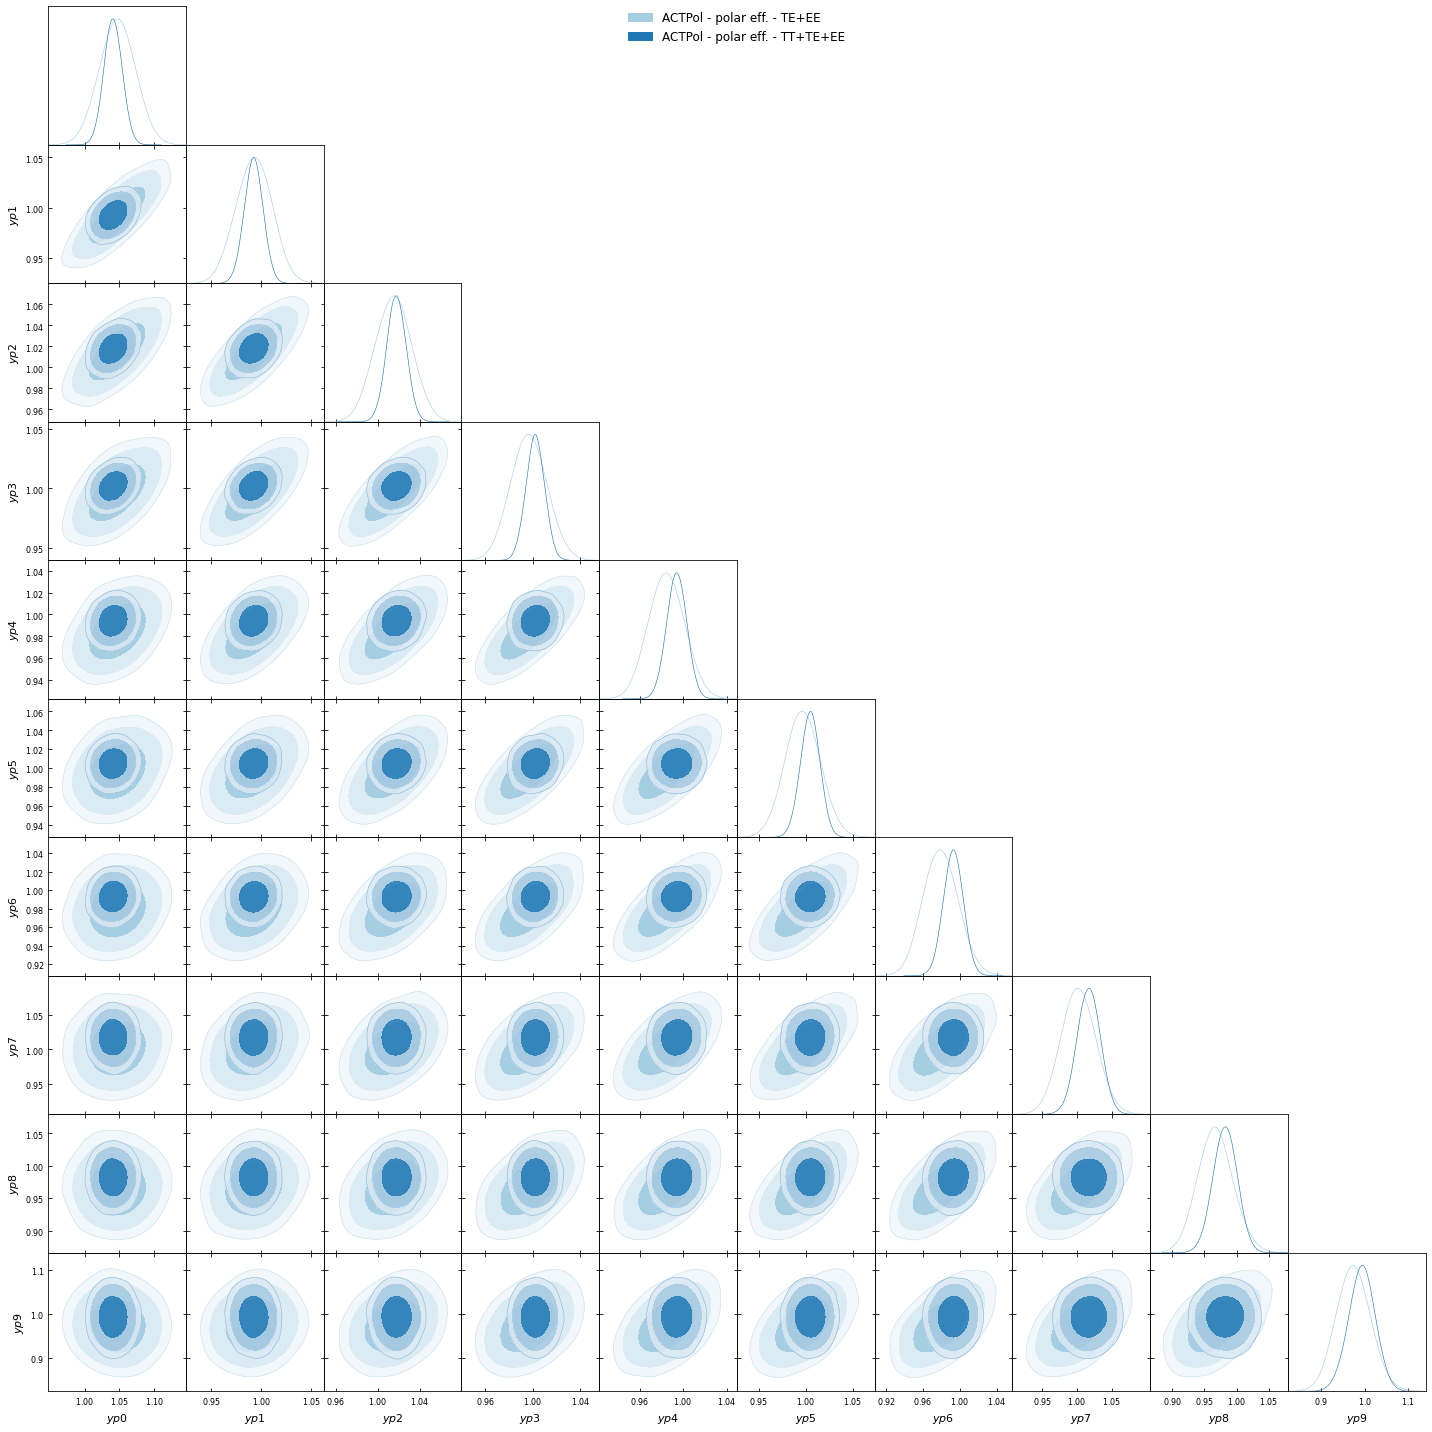

In [30]:
g.triangle_plot(
    samples[:2],
    polareff_params,
    filled=True,
    legend_labels=mcmc_samples.keys(),
    colors=colors,
    diag1d_kwargs={"colors": colors},
)

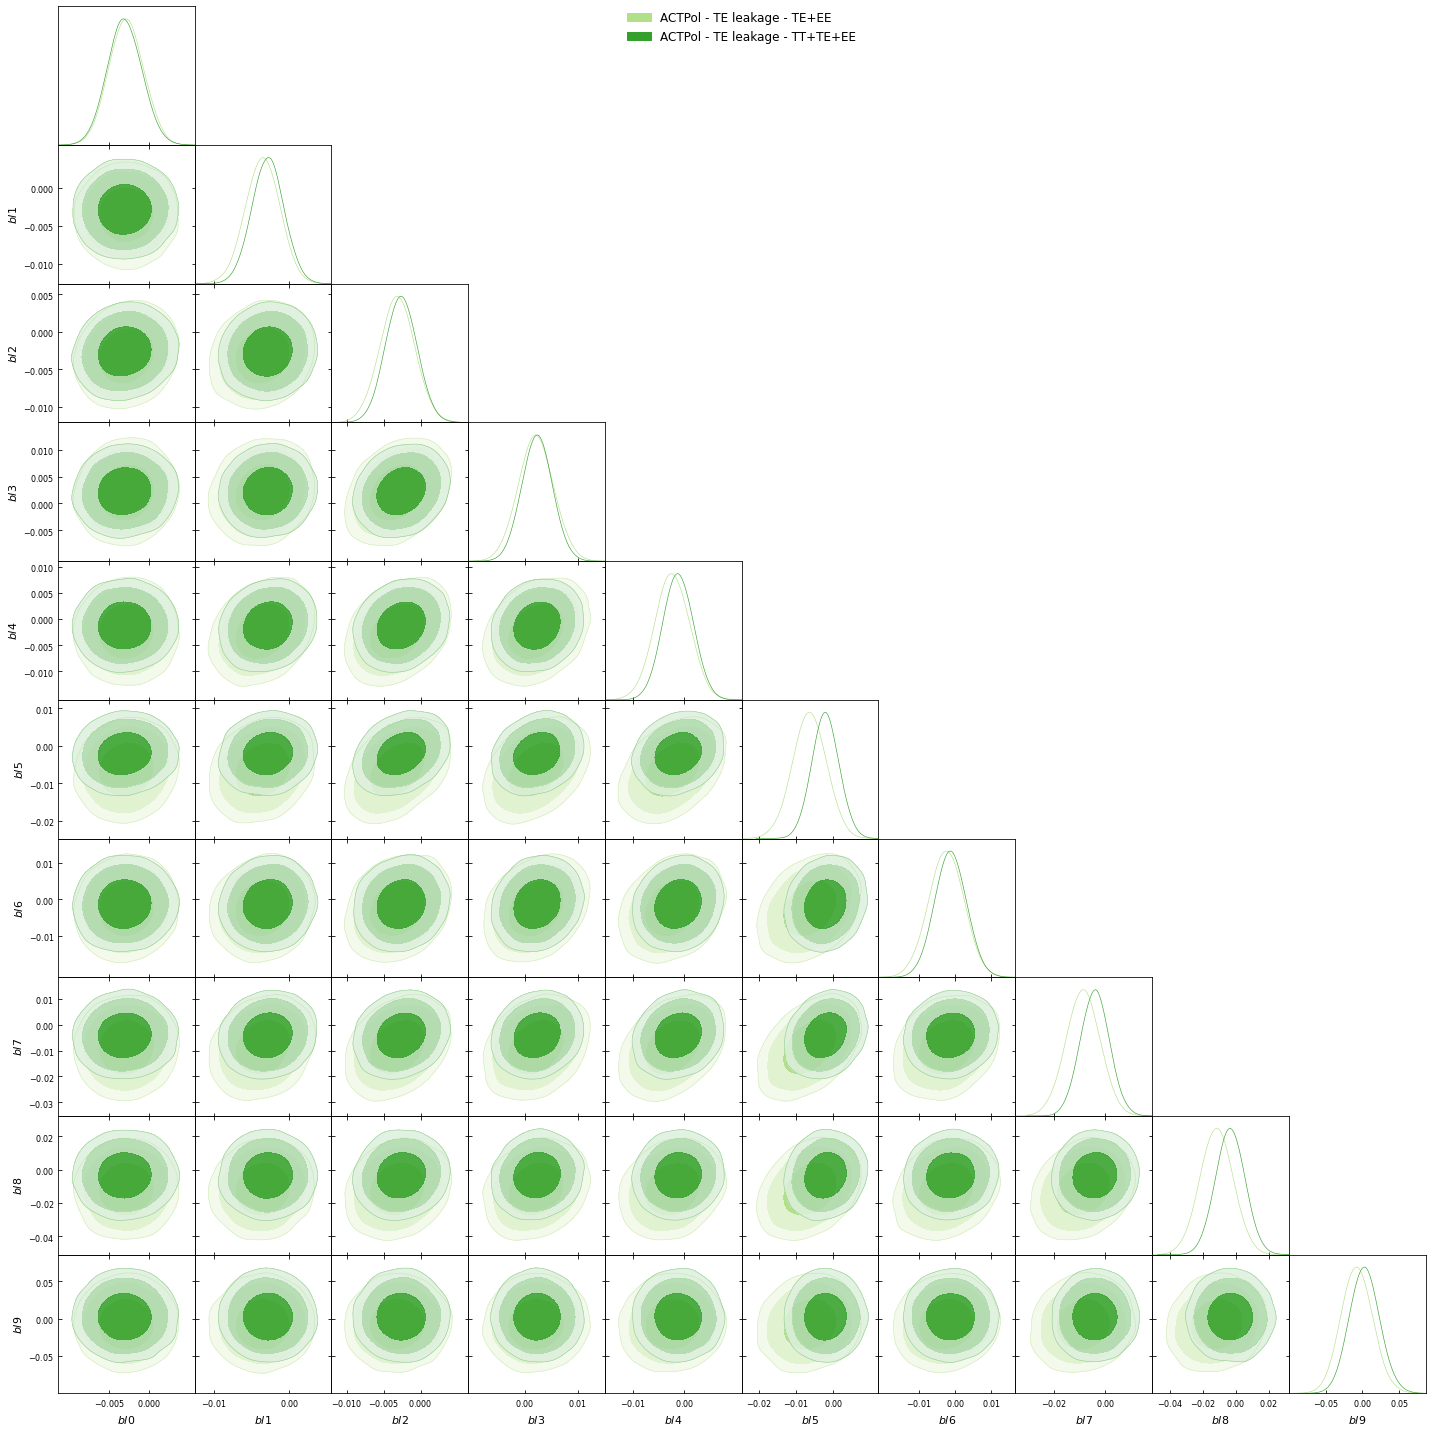

In [31]:
g.triangle_plot(
    samples[2:],
    leakage_params,
    filled=True,
    legend_labels=list(mcmc_samples.keys())[2:],
    colors=colors[2:],
    diag1d_kwargs={"colors": colors[2:]},
)

### Correlation plot



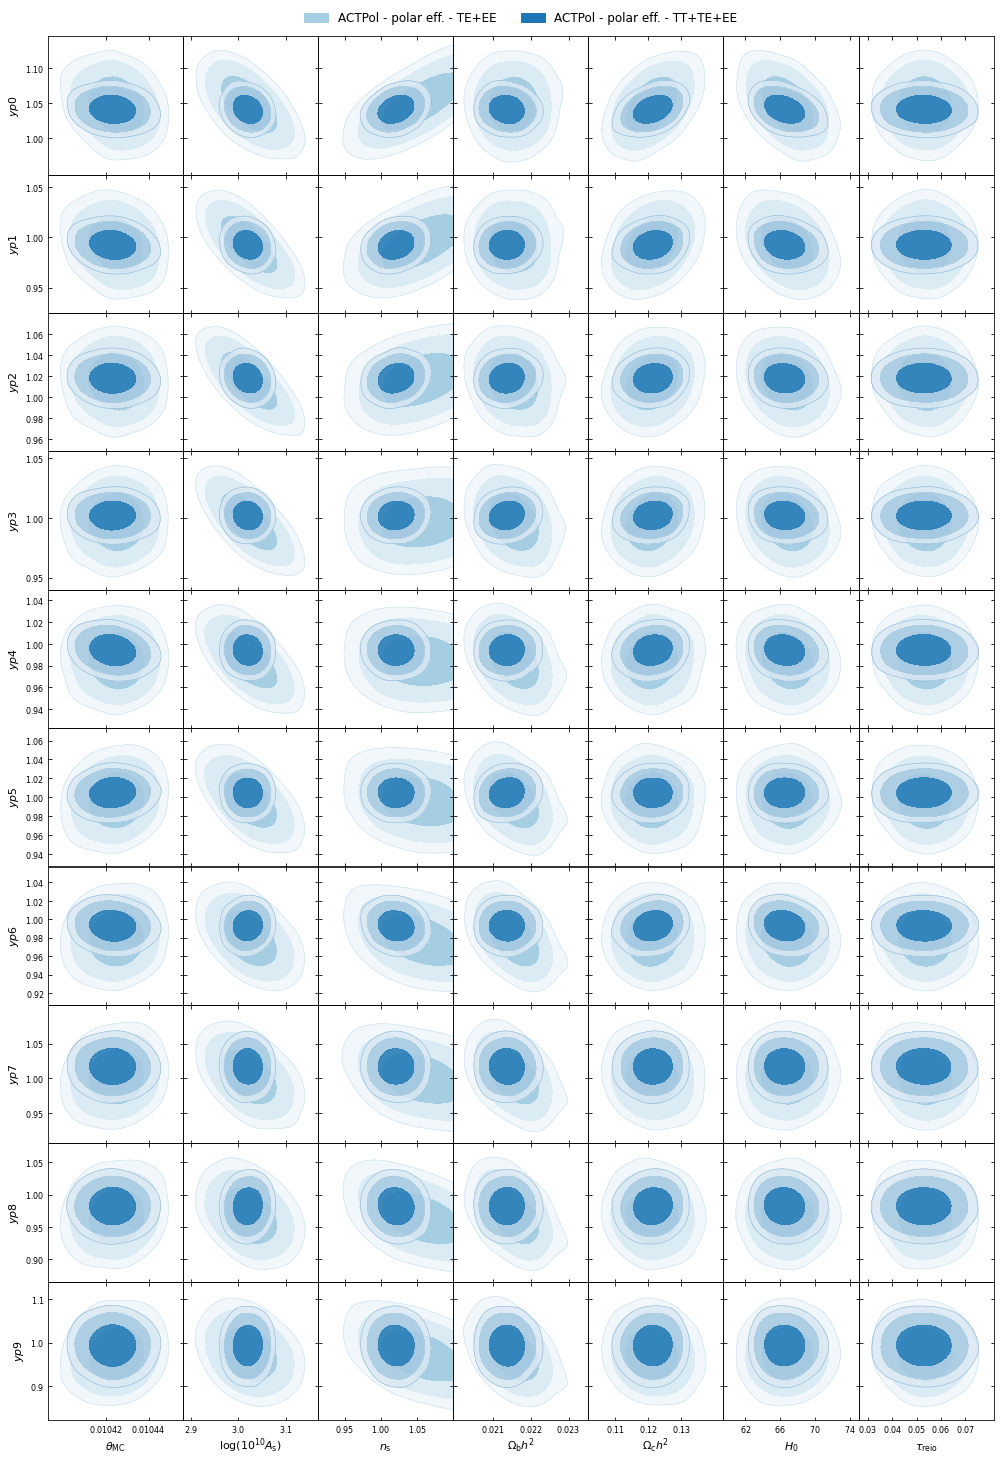

In [32]:
g.rectangle_plot(
    cosmo_params,
    polareff_params,
    roots=samples[:2],
    filled=True,
    legend_labels=mcmc_samples.keys(),
    colors=colors,
);

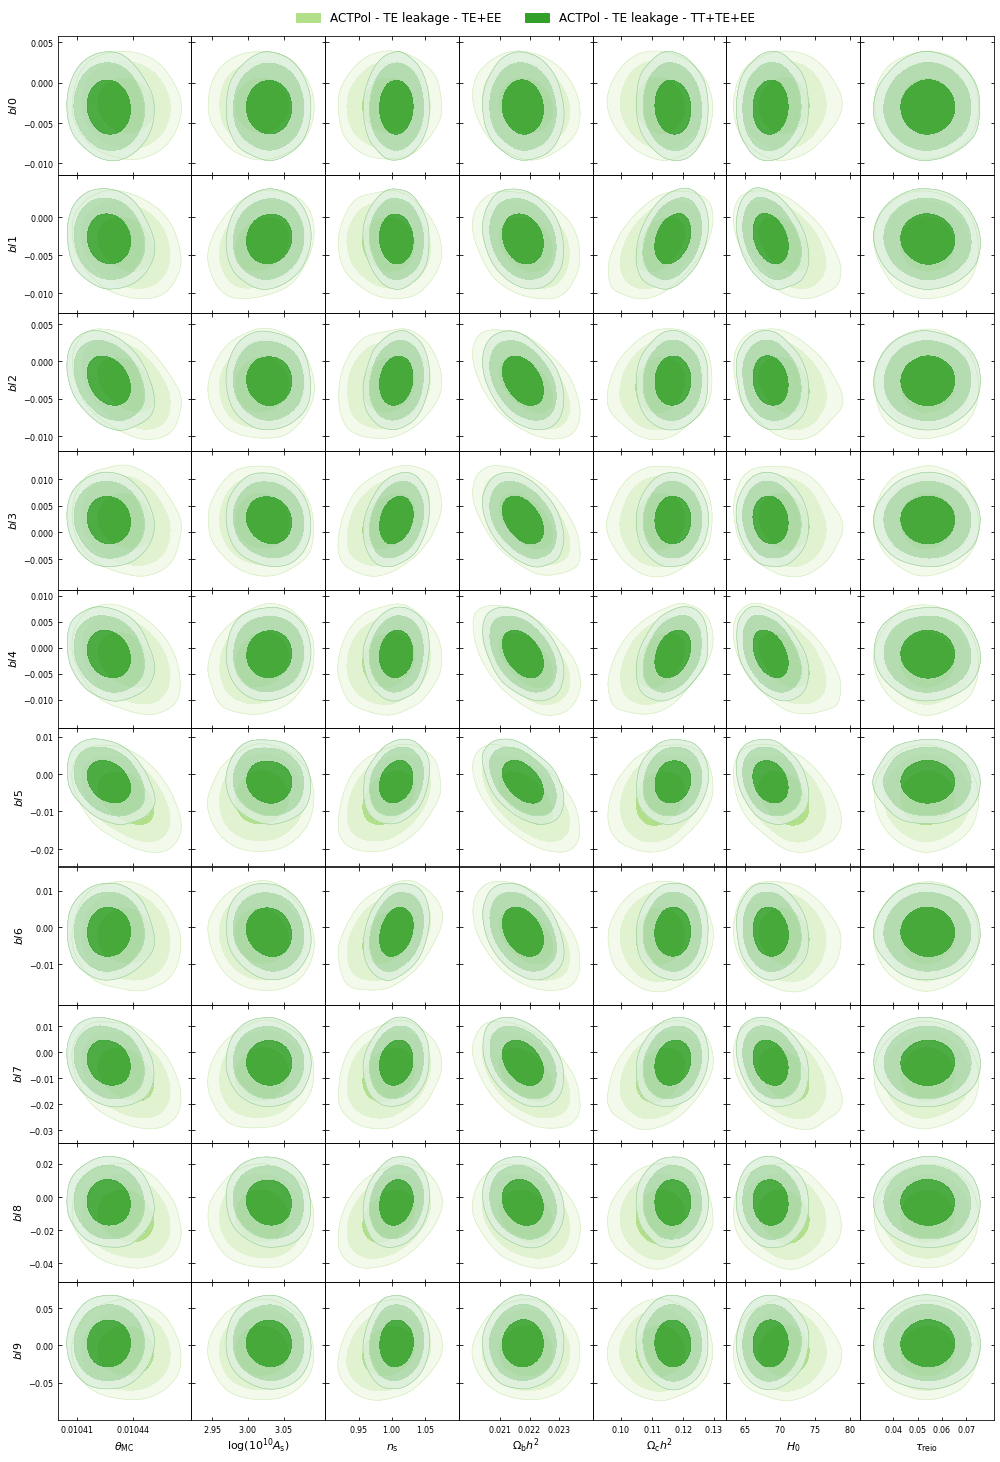

In [33]:
g.rectangle_plot(
    cosmo_params,
    leakage_params,
    roots=samples[2:],
    filled=True,
    legend_labels=list(mcmc_samples.keys())[2:],
    colors=colors[2:],
);

In [34]:
def plot_correlation(sample, nuisance_params, ax=None):
    params = cosmo_params.copy()
    params.remove("H0")
    params += nuisance_params
    if ax is None:
        ax = plt.gca()
    im = ax.imshow(sample.getCovMat().correlation(), cmap="RdBu", vmin=-1, vmax=+1)
    ax.set_xticks(np.arange(len(params)))
    ax.set_xticklabels(params, rotation="vertical")
    ax.set_yticks(np.arange(len(params)))
    ax.set_yticklabels(params)
    return im

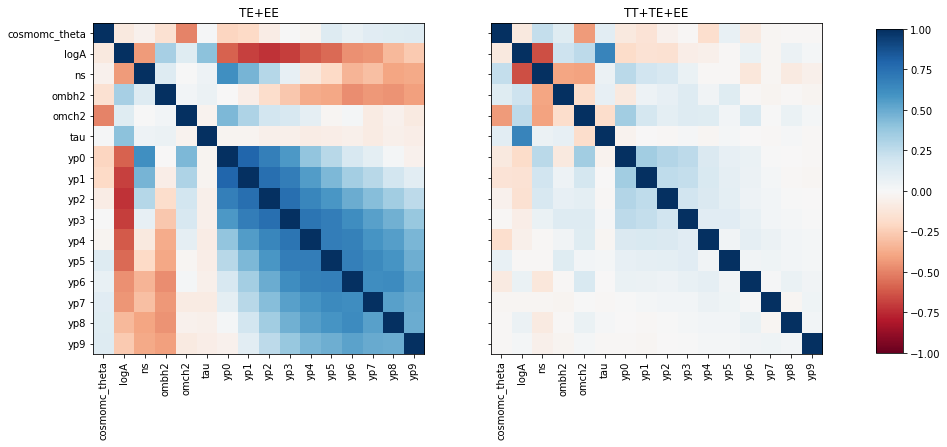

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15), sharey=True)
im = plot_correlation(samples[0], polareff_params, ax=axes[0])
im = plot_correlation(samples[1], polareff_params, ax=axes[1])
axes[0].set_title("TE+EE")
axes[1].set_title("TT+TE+EE")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.35, 0.025, 0.3])
fig.colorbar(im, cax=cbar_ax);

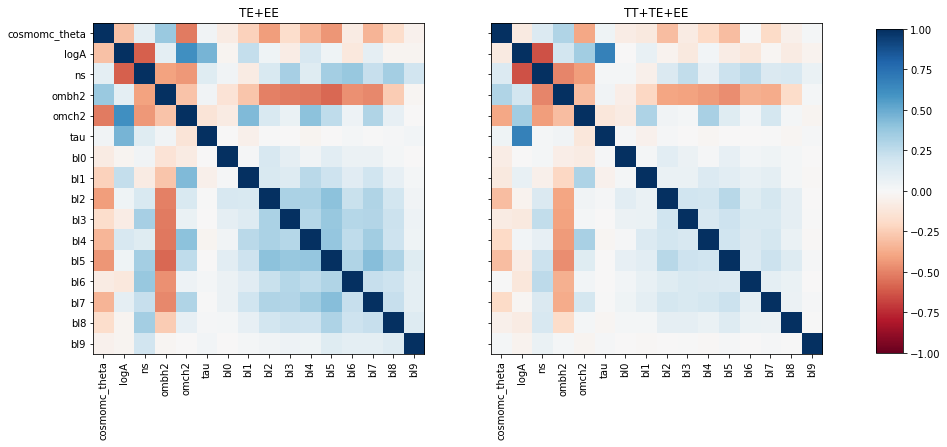

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15), sharey=True)
im = plot_correlation(samples[2], leakage_params, ax=axes[0])
im = plot_correlation(samples[3], leakage_params, ax=axes[1])
axes[0].set_title("TE+EE")
axes[1].set_title("TT+TE+EE")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.35, 0.025, 0.3])
fig.colorbar(im, cax=cbar_ax);

### Results

In [19]:
import ipywidgets as widgets


def show_table(samples, params):
    return widgets.HBox(
        [
            widgets.Image(
                value=sample.getTable(limit=1, paramList=params + ["chi2"])
                .tablePNG(dpi=150, bytesIO=True)
                .read()
            )
            for sample in samples
        ]
    )

In [20]:
show_table(samples[:2], cosmo_params + polareff_params)

In [21]:
show_table(samples[2:], cosmo_params + leakage_params)

In [37]:
from scipy import stats


def plot_params(samples, labels, colors, params, expected=1.0):
    plt.figure(figsize=(8, 6))
    gs = plt.GridSpec(4, 1)
    main = plt.subplot(gs[:3], xticklabels=[])
    dev = plt.subplot(gs[-1])
    for sample, label, color in zip(samples, labels, colors):
        x = np.arange(len(params))
        y = sample.mean(params)
        yerr = sample.std(params)
        chi2 = np.sum((y - expected) ** 2 / yerr ** 2)
        label = f"{label} - $\chi^2$/ndof = {chi2:.2f}/15 - PTE = {stats.chi2.sf(chi2, 15):.2f}"
        main.errorbar(x, y, yerr=yerr, fmt="o", label=label, color=color)
        dev.errorbar(x, (y - expected) / yerr, fmt="o", color=color)
    main.axhline(expected, color="gray", ls="--")
    main.legend(loc="lower left", labelcolor=colors)
    dev.set_xticks(x)
    dev.set_xticklabels(params)
    dev.set_ylabel(r"$\sigma$")

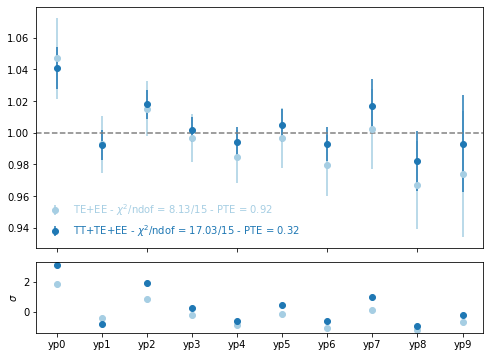

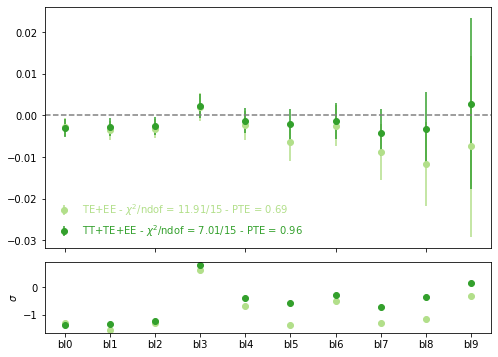

In [38]:
plot_params(samples[:2], ["TE+EE", "TT+TE+EE"], colors[:2], polareff_params)
plot_params(samples[2:], ["TE+EE", "TT+TE+EE"], colors[2:], leakage_params, expected=0)